In [303]:
import scipy.signal, scipy.io, os, scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
%matplotlib inline

In [304]:
sampleRate = 1000
dataFolder = 'Real_Data'
fileList = os.listdir(dataFolder)
dataset = []
for file in fileList:
    if file.endswith('.mat'):
        data = scipy.io.loadmat(dataFolder + '/' + file)
        dataset.append(data['val'].squeeze())

In [305]:
idxTrial = np.random.randint(len(dataset))
print(f'Dataset {idxTrial}')
data = dataset[12]

Dataset 8


In [306]:
def plotPSD(data, sampleRate, title):
    freq, PSD = scipy.signal.welch(data, sampleRate, window=scipy.signal.windows.hann(1024))
    fig, ax = plt.subplots()
    ax.plot(freq, PSD.transpose())
    ax.set_xlim([0, 200])
    ax.set_yscale('log')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD')
    ax.set_title(title)
    ax.grid(True)
    return fig, ax

def plotDataSection(data, title, 
    startTime=0, 
    endTime=None, 
    sampleRate=24e3,
    idxPeakMarker=np.array([]),
    ax=None,
    ):
    '''
    plot data in a certain interval.
    input:
    - data: [idx of channels, idx of datapoints]
    '''
    if data.ndim == 1:
        data = data.reshape(1, -1)
    if endTime is None:
        endTime = data.shape[-1]/sampleRate
        sectionLength = data.shape[-1]
        dataSection = data
    else:
        idxStart = int(startTime*sampleRate)
        idxEnd = int(endTime*sampleRate)
        sectionLength = idxEnd - idxStart
        dataSection = data[:, idxStart: idxEnd]
    time = np.linspace(startTime, endTime, num=sectionLength)
    if ax == None:
        fig, ax = plt.subplots()
    for idxCh, chData in enumerate(dataSection):
        ax.plot(time, chData, label=f'Ch {idxCh}')
        if idxPeakMarker.any():
            ax.plot(time[idxPeakMarker], chData[idxPeakMarker], '*')
    ax.set_title(title)
    ax.set_xlim([startTime, endTime])
    ax.set_xlabel('time [s]')
    ax.set_ylabel('voltage [uv]')
    ax.grid(True)
    ax.legend()
    return fig, ax

def plotChannels(data, title, startTime=20, endTime=25, isICA = True):
    idxStart = int(startTime*sampleRate)
    idxEnd = int(endTime*sampleRate)
    sectionLength = idxEnd - idxStart
    dataSection = data[:, idxStart: idxEnd]
    time = np.linspace(startTime, endTime, num=sectionLength)
    fig, ax = plt.subplots(4,1)
    for i in range(4):   
        ax[i].plot(time, dataSection[i])
        if (isICA):
            ax[i].set_ylim([-7,7])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Original PSD'}, xlabel='frequency [Hz]', ylabel='PSD'>)

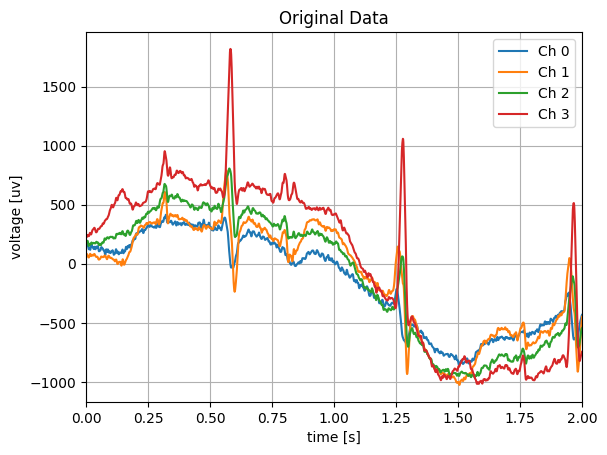

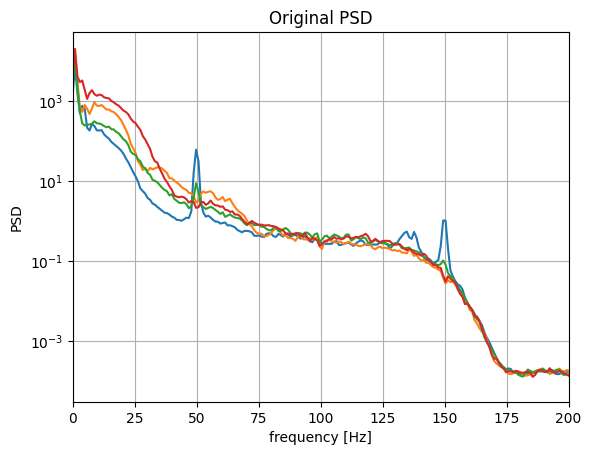

In [307]:
plotDataSection(data, 'Original Data', sampleRate=sampleRate ,startTime = 0, endTime= 2)
plotPSD(data, sampleRate, 'Original PSD')



-976.0
-1279.0
-1314.0
-1511.0


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'PSD after artifact canceling'}, xlabel='frequency [Hz]', ylabel='PSD'>)

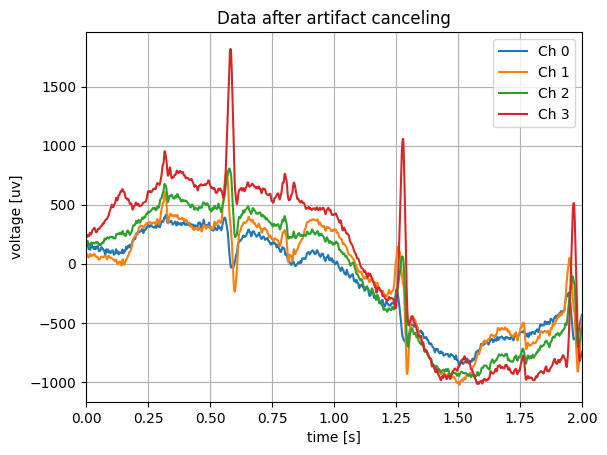

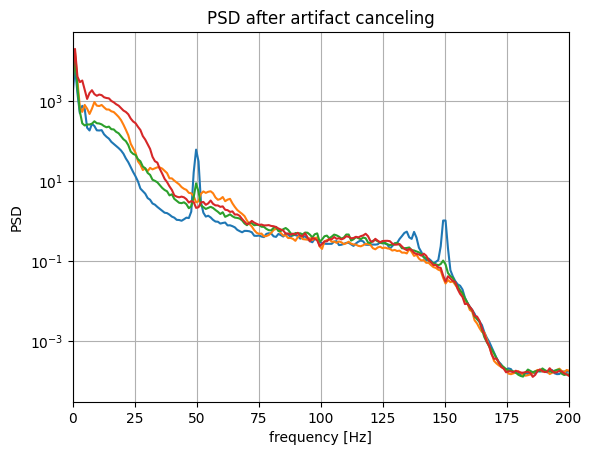

In [308]:
for i in range(data.shape[0]):    
    test = data[i]< 0
    heightThreshold = np.percentile((data[i]).flatten(), 0.2)
    print(heightThreshold)
    data[i, data[i]< heightThreshold * 3] = heightThreshold   ##### Make this threshold automatic





plotDataSection(data, 'Data after artifact canceling', sampleRate=sampleRate,endTime= 2)
plotPSD(data, sampleRate, 'PSD after artifact canceling')

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'PSD after baseline removal'}, xlabel='frequency [Hz]', ylabel='PSD'>)

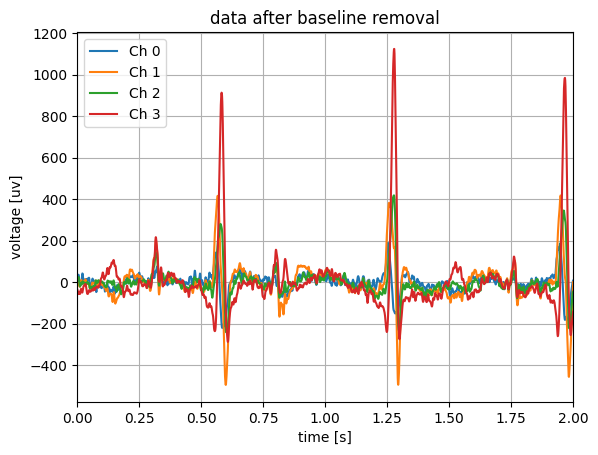

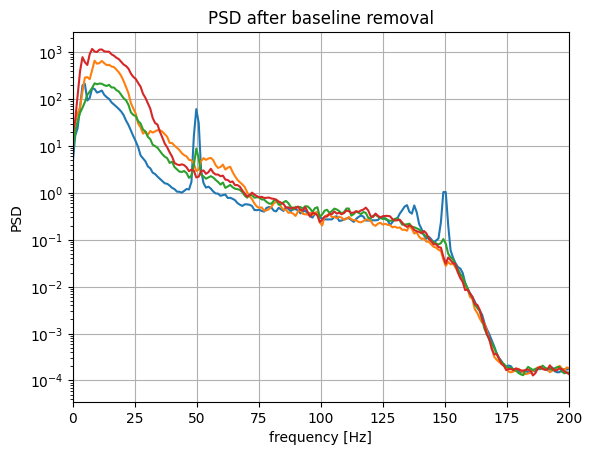

In [309]:
highpassSOS = scipy.signal.butter(1, 4, 'lowpass', fs=sampleRate, output='sos')
highpassfiltData = scipy.signal.sosfiltfilt(highpassSOS, data, axis=1)

data = data - highpassfiltData

plotDataSection(data, 'data after baseline removal', sampleRate=sampleRate, endTime= 2)
plotPSD(data, sampleRate, 'PSD after baseline removal')

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'PSD after powerline removal'}, xlabel='frequency [Hz]', ylabel='PSD'>)

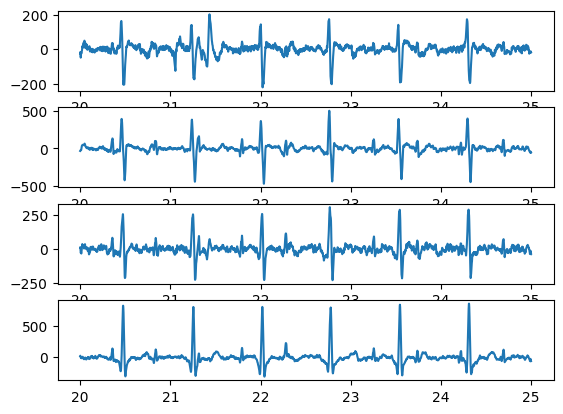

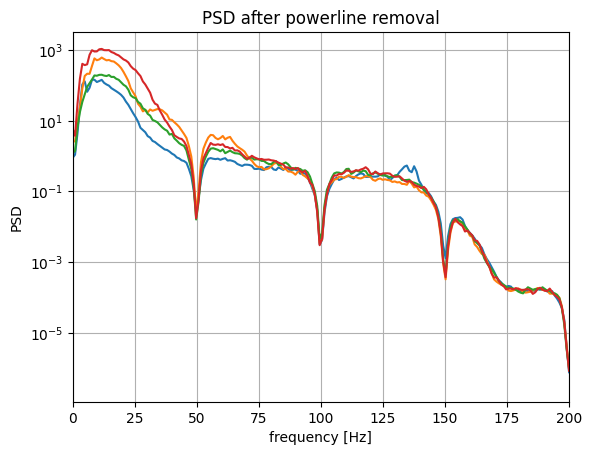

In [310]:
b_notch,a_notch = scipy.signal.iircomb(50,10,fs = sampleRate)
notchData = scipy.signal.filtfilt(b_notch,a_notch,data)

plotChannels(notchData, 'data after powerline removal', isICA = False)
plotPSD(notchData, sampleRate, 'PSD after powerline removal')


In [311]:
numCh = data.shape[0]
transform = FastICA(n_components=numCh, algorithm = 'deflation', whiten='unit-variance', fun = 'logcosh',  max_iter=300)
ICAData = transform.fit_transform(notchData.T).T

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'ICA'}, xlabel='time [s]', ylabel='voltage [uv]'>)

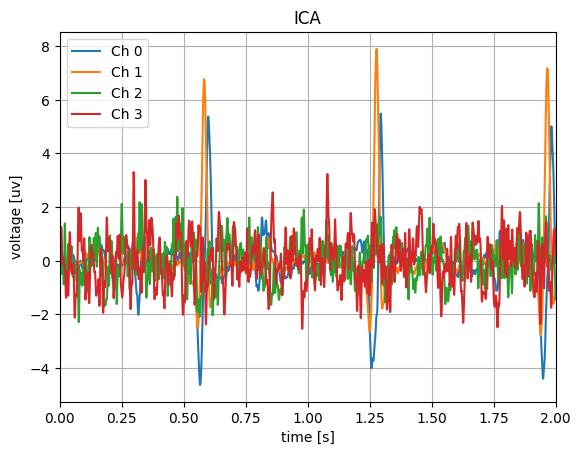

In [312]:
plotDataSection(ICAData, 'ICA', sampleRate=sampleRate, endTime = 2)


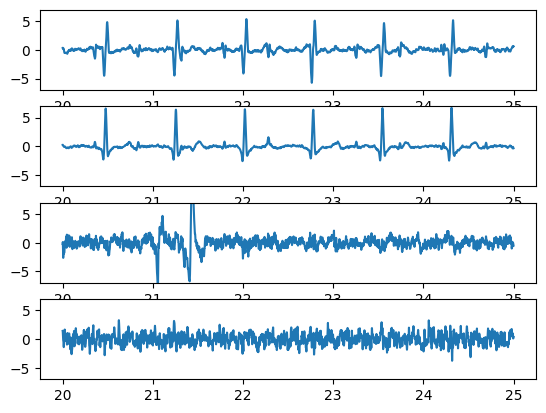

In [313]:
plotChannels(ICAData, 'test')